In [4]:
import Base.bp2DState
from Base.bp2DSimpleHeuristics import single_type_heuristic, first_fit, next_fit, most_enclosed_position, max_rest, \
    best_fit, first_fit_decreasing, next_fit_decreasing, get_all_heuristics, random_fit
from Base.bp2DState import State
from Base.bpReadWrite import ReadWrite
from Base.bp2DBox import Box
from Base.bpStateGenerators import random_state_generator, state_generator
import time

from Base.bp2DPlot import plot_packing_state
from Base.bp2DSimpleHeuristicsFunctions import most_enclosed_position_in_bin
from Base.bp2DState import Bin
from Base.bp2DState import Action, State
from Base.bpUtil import *
from Base.bpStateGenerators import random_state_generator


In [99]:
import matplotlib.pyplot as plt

In [ ]:
state = state_generator(bin_size=(10, 10),
                    box_list=[(1, (1, 10)), (1, (1, 9)), (1, (9, 1)), (1, (1, 8)), (1, (8, 1)),
                              (1, (1, 7)), (1, (7, 1)), (1, (1, 6)), (1, (6, 6))], seed=10)

In [43]:
path = "test_instances/heuristics_test_state_big" 

In [44]:
state = ReadWrite.read_state(path)

In [5]:
def ffd_fast(state: State, plot_result=False, plot_steps=False, plot_name=None):
    '''ffd'''
    start = time.time()
    step = 0
    name = 'ffd_plot'
    if plot_name is not None:
        name = plot_name
    sort_boxes_in_state(state)
    while state.has_open_boxes():
        box = state.get_next_open_box()
        first_fit(state, box)

        if plot_steps:
            plot_packing_state(state=state, step=step, fname=f"./vis/{name}_step")
            step += 1
    if plot_result:
        plot_packing_state(state, fname=f"./vis/{name}_result")
    state.solution_runtime = time.time() - start

In [46]:
ffd_fast(state)


KeyboardInterrupt: 

In [49]:
init = ReadWrite.read_state(path)

In [ ]:
f"Is solution of {'fast ffd'} valid? {state.is_valid(init)}!"

In [ ]:
len(state.bins)

In [ ]:
len(init.boxes_open)

In [20]:
solution = ReadWrite.read_state(path)
single_type_heuristic(solution, most_enclosed_position)
print(f"Is solution of {'most_enclosed_position'} valid? {solution.is_valid(init)}!")
print(f"{len(solution.bins)}")

Is solution of most_enclosed_position valid? True!
77


In [23]:
solution.solution_runtime

22.60828161239624

In [22]:
state.solution_runtime

7.8712358474731445

In [54]:
def ffd_shaker(state: State, plot_result=False, plot_steps=False, plot_name=None, speed_mode = False):
    '''ffd shaker'''
    start = time.time()
    step = 0
    name = 'ffd_shaker_plot'
    if plot_name is not None:
        name = plot_name
    sort_boxes_in_state(state)
    fill_state = False
    last_bin = 0
    while state.has_open_boxes():
        box = state.get_next_open_box()
        
        if fill_state:
        # in this state we try to fit smallest containers in remaining space, without creating new bins
            placement_success = False
            for i in range(last_bin, len(state.bins)):
                placement_success = state.place_box_in_bin(box, i)
                if placement_success:
                    break

            if not placement_success:
                state.boxes_open = state.boxes_open[::-1]
                fill_state = False
                if speed_mode:
                    last_bin = len(state.bins) - 1
                    
        else:
         # in this state we create containers, until find the container, which fits into created bins 
            placement_success = False
            for i in range(last_bin, len(state.bins)):
                placement_success = state.check_if_fits_somewhere_in_box(box, i)
                if placement_success:
                    state.boxes_open = state.boxes_open[::-1]
                    fill_state = True
                    break

            if not placement_success:
                state.open_new_bin()
                state.place_box_in_bin_at_pnt(box, -1, Point(0, 0))
            

        if plot_steps:
            plot_packing_state(state=state, step=step, fname=f"./vis/{name}_step")
            step += 1
    if plot_result:
        plot_packing_state(state, fname=f"./vis/{name}_result")
    state.solution_runtime = time.time() - start

### shaker ffd solution

In [47]:
solution = ReadWrite.read_state(path)
ffd_shaker(solution)
#print(f"Is solution of {'shaker ffd'} valid? {solution.is_valid(init)}!")
print(f"{len(solution.bins)}")

Is solution of shaker ffd valid? False!
1963


In [50]:
#validity works slow!
print(f"Is solution of {'shaker ffd'} valid? {solution.is_valid(init)}!")

Is solution of shaker ffd valid? True!


In [48]:
solution.solution_runtime

2395.952022075653

### comparing with mr - which is relatevly fast

In [51]:
solution_mr = ReadWrite.read_state(path)
single_type_heuristic(solution_mr, max_rest)
print(f"{len(solution_mr.bins)}")

2728


In [52]:
solution_mr.solution_runtime

16.820357084274292

### comparing with nf - which is the fastest

In [58]:
solution_nf = ReadWrite.read_state(path)
single_type_heuristic(solution_nf, next_fit)
print(f"{len(solution_nf.bins)}")

2850


In [59]:
solution_nf.solution_runtime

5.062244892120361

### shaker ffd with heuristic

In [55]:
solution_fast = ReadWrite.read_state(path)
ffd_shaker(solution_fast, speed_mode=True)
print(f"{len(solution_fast.bins)}")

1963


In [57]:
solution_fast.solution_runtime

9.30950665473938

### extremes gen

In [61]:
test_state = random_state_generator((10, 10),5000,1,3,1,3)

In [65]:
for box in random_state_generator((10, 10),5000,8,10,8,10).boxes_open:
    test_state.append_open_box(box)

In [72]:
ReadWrite.write_state(path=f"test_instances/extremes_10k", state=test_state)

### MR

In [74]:
solution_mr = ReadWrite.read_state(f"test_instances/extremes_10k")
single_type_heuristic(solution_mr, max_rest)
print(f"{len(solution_mr.bins)}")

5224


In [75]:
solution_mr.solution_runtime

20.134422063827515

### fast shaker ffd

In [79]:
solution_fast = ReadWrite.read_state(f"test_instances/extremes_10k")
ffd_shaker(solution_fast, speed_mode=True)
print(f"{len(solution_fast.bins)}")

5049


In [80]:
solution_fast.solution_runtime

1162.087031841278

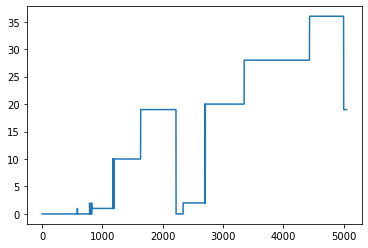

In [104]:
available_cap = []
for binn in solution_fast.bins:
    available_cap.append(binn.capacity_available())
plt.plot(available_cap);

In [ ]:
plt.fig

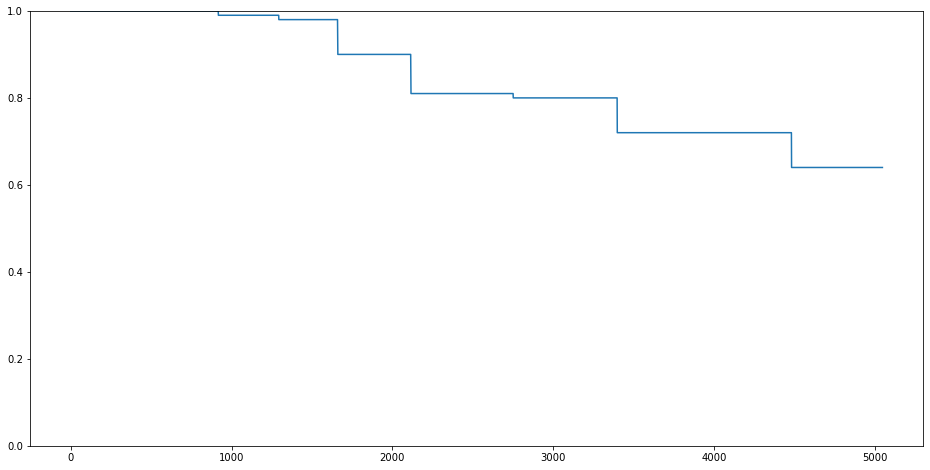

In [121]:
density = []
for binn in solution_fast.bins:
    density.append((100 - binn.capacity_available()) / 100)
density = sorted(density, key = lambda x: -x)
plt.figure(figsize=(16,8))
plt.ylim(bottom=0)
plt.plot(density);

### runtime of fast ffd really depends on disribution

### let's check results on default shaker ffd

In [82]:
solution_fast = ReadWrite.read_state(f"test_instances/extremes_10k")
ffd_shaker(solution_fast)
print(f"{len(solution_fast.bins)}")
print(solution_fast.solution_runtime)

5049
1894.6353840827942


In [ ]:
### runtime of fast ffd really depends on disribution

### on bf

In [84]:
solution_bf = ReadWrite.read_state(f"test_instances/extremes_10k")
single_type_heuristic(solution_bf, best_fit)

TypeError: object of type 'State' has no len()

In [85]:
print(f"{len(solution_bf.bins)}")
print(solution_bf.solution_runtime)

5200
1237.2432482242584


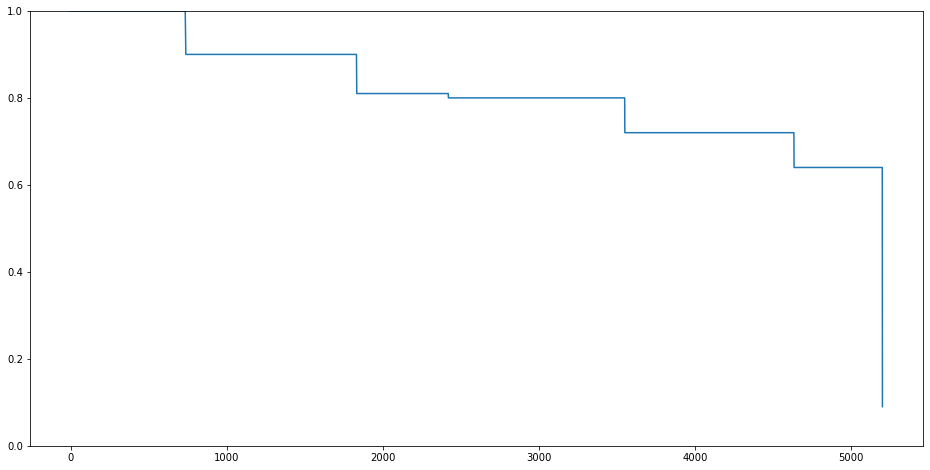

In [119]:
density_bf = []
for binn in solution_bf.bins:
    density_bf.append((100 - binn.capacity_available()) / 100)
density_bf = sorted(density_bf, key = lambda x: -x)
plt.figure(figsize=(16,8))
plt.ylim(bottom=0)

plt.plot(density_bf);

In [7]:
solution_ffd = ReadWrite.read_state(f"test_instances/extremes_10k")
ffd_fast(solution_ffd)
print(f"{len(solution_ffd)}")
print(solution_ffd.solution_runtime)

TypeError: object of type 'State' has no len()